# CYPLAN101 Fall 2025 - Lab 10 (Part I): OSMnx and GTFS Data

## Learning Objectives:
1. Download and visualize street network data using OSMnx
2. Calculate shortest paths between two locations
3. Generate isochrones (walksheds/service areas)
---


In [1]:
# Run this cell to import dependencies
try:
    import osmnx as ox
except ModuleNotFoundError:
    !pip install osmnx geopandas matplotlib networkx

import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point
import warnings
warnings.filterwarnings("ignore")

ox.settings.use_cache = True
ox.settings.log_console = True

## Part I: Download the OSMnx data

In this part of the exercise you will access and download data from OpenStreetMap using the OSMnx library.

> **For reference, the following are key functions covered in the course of this exercise:**
1. ox.graph_from_place() - Download street network"
2. ox.distance.nearest_nodes() - Find closest network node"
3. ox.add_edge_speeds() & ox.add_edge_travel_times() - Add routing attributes"
4. ox.shortest_path() - Calculate optimal route"
5. ox.plot_graph_route() - Visualize routes"
6. nx.ego_graph() - Generate isochrones/service areas"


### Step 1: Download the walkable street network.

We will begin this exerciseby downloading the walkable street network for
```
"Berkeley, CA, USA"
```
To do this, you will use the "graph_from_place" method in OSMnx.

##❗️ Try it Out ❗️
Edit the arguments in the code cell below to retrieve the data and plot the result.

Network downloaded: 10297 nodes, 28196 edges


<Figure size 1000x1000 with 0 Axes>

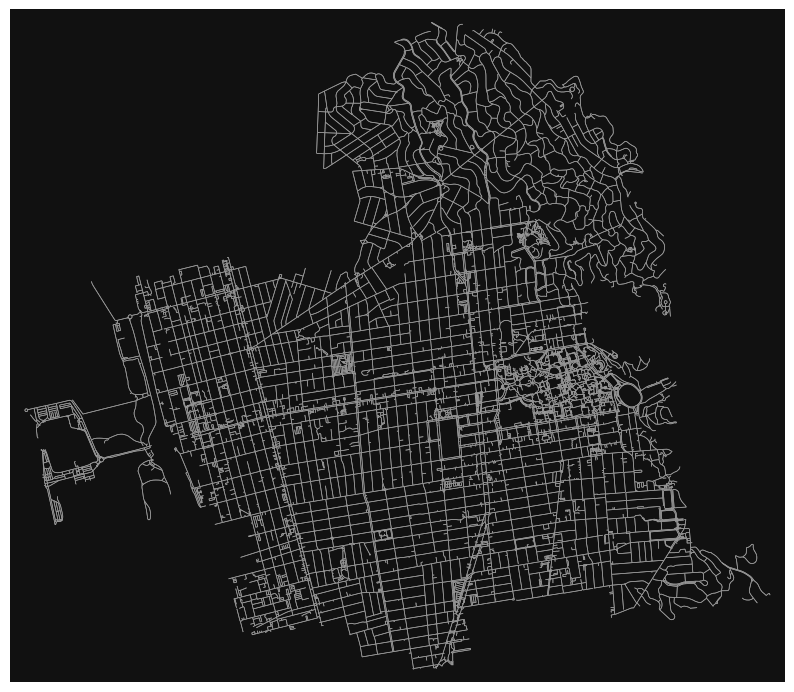

In [2]:
placeName = 'Berkeley, California, USA'

# Download walkable street network
berkeleyGraph = ox.graph_from_place(placeName, network_type='walk')
print(f"Network downloaded: {len(berkeleyGraph.nodes)} nodes, {len(berkeleyGraph.edges)} edges")

plt.figure(figsize=(10,10))
ox.plot_graph(berkeleyGraph, node_size=0, edge_linewidth=0.5, figsize=(10, 10))
plt.show()

### Step 2: Calculate the shortest path
In this step you will find the shortest path between two locations, the Downtown Berkeley BART station, and Wurster Hall (you are here!)

##❗️ Try it Out ❗️
Given the following information about the locations of the BART Station and Wurster Hall, edit the code cell below to find the nearest graph nodes corresponding to the locations.

```
# Origin: Downtown Berkeley BART Station (37.8703, -122.2681)

# Destination: Wurster Hall (37.8708, -122.2547)
```
> **Hint:** To do this, you will want to use `distance.nearest_edges`.

In [3]:
# Use the space below to define the origin and destination locations.
originLat, originLon = (37.8703, -122.2681)

# Destination: Wurster Hall (College of Environmental Design)
destLat, destLon = (37.8708, -122.2547)

# Use nearest_nodes to get the closest graph node IDs (nearest_edges returns an edge tuple)
# Note: nearest_nodes takes X (lon), Y (lat)
originNode = ox.distance.nearest_nodes(berkeleyGraph, originLon, originLat)
destNode = ox.distance.nearest_nodes(berkeleyGraph, destLon, destLat)

print(f"Origin node: {originNode}, Destination node: {destNode}")

Origin node: 53050568, Destination node: 8467880860


### Step 3: Calculate travel times along the edges in the graph.

To determine the most expeditious route, we will need to calculate the travel times along the edges in the graph.

> **Hint #1:**
`osmnx.routing.add_edge_travel_times(G)`
calculates free-flow travel time along each edge, based on length and speed_kph attributes.  

<br>

> **Hint #2:** Before running add_edge_travel_times, you will first need to calculate speed.  This is done via `add_edge_speeds`.  To run this, all edges must have length and speed_kph attributes and all their values must be non-null.

##❗️ Try it Out ❗️

Edit the code cell below to calculate travle times along the edges in the graph and calculate the shortest path by travel time.  There is a handy function in OSMnx that allows for this calculation, `shortest_path()`.

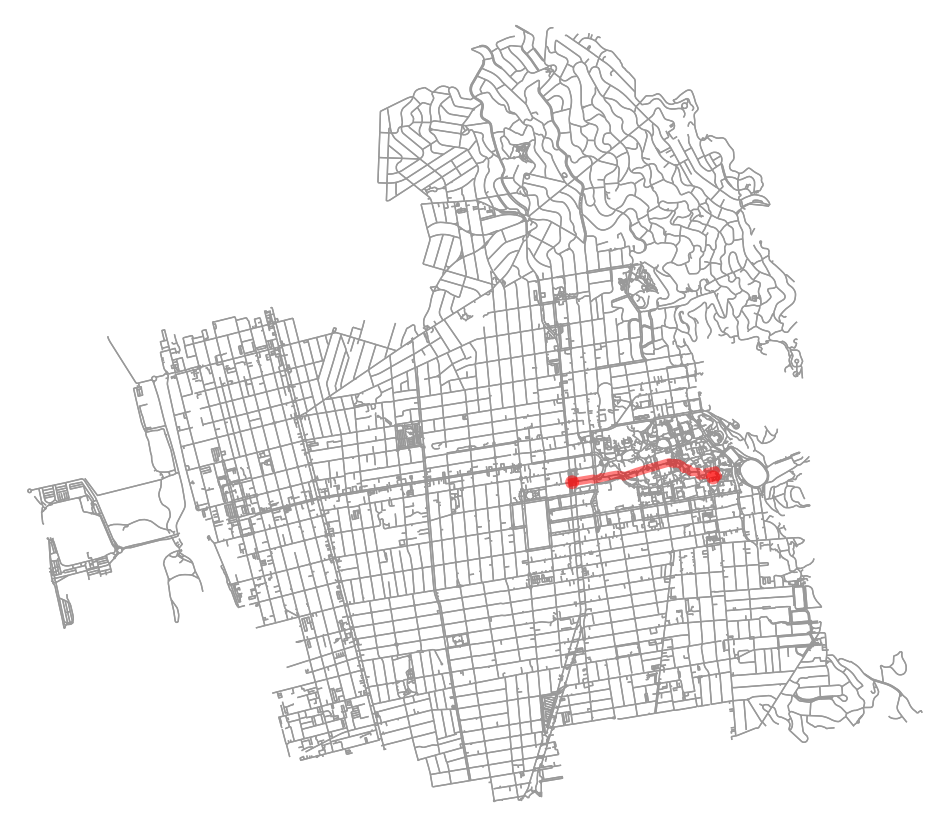

In [4]:
# Use the space below to add speed and travel time attributes to berkeleyGraph edges
berkeleyGraph = ox.add_edge_speeds(berkeleyGraph)
berkeleyGraph = ox.add_edge_travel_times(berkeleyGraph)

# Calculate shortest path by travel time
odShortestRoute = ox.shortest_path(berkeleyGraph, originNode, destNode, weight="travel_time")

# When you are done, uncomment the following code to visualize the route
fig, ax = ox.plot_graph_route(
    berkeleyGraph, odShortestRoute,
    route_linewidth=6,
    route_color='red',
    node_size=0,
    bgcolor='white',
    figsize=(12, 12),
)

### Step 4: Learn more about your shortest route
Run the cell below to view basic route statistics.

In [5]:
routeLength = sum(ox.routing.route_to_gdf(berkeleyGraph, odShortestRoute)['length'])
routeTime = sum(ox.routing.route_to_gdf(berkeleyGraph, odShortestRoute)['travel_time'])
print(f"\nRoute Statistics:")
print(f"  Length: {routeLength:.0f} meters ({routeLength/1609:.2f} miles)")
print(f"  Travel time: {routeTime/60:.1f} minutes")


Route Statistics:
  Length: 1419 meters (0.88 miles)
  Travel time: 2.1 minutes


## Part II: Produce Isochrones to Represent Walksheds Around Metro Stops
This part of the exercise will require you to produce isochrones.  As the name implies, isochrones are polygons that represent areas of equal travel times from their centers.

Isochrones are generally regarded as more accurate representations of travel distance than polygons produced using buffers which typically only represent the euclidean distance from a point of origin.

### Step 1: Reproject the data
In order to work with the graph data  you will need to reproject it to convert the units from degrees to meters.  One degree of longitude ≠ one degree of latitude in distance, but one *meter* is one meter no matter the axis!



In [6]:
# Run the following code cell to project graph and origin point for accurate distance calculations
berkeleyGraphProj = ox.project_graph(berkeleyGraph)

nodesGdf = ox.graph_to_gdfs(berkeleyGraphProj, edges=False)
centerPointProj = ox.projection.project_geometry(
    Point(originLon, originLat),
    crs='EPSG:4326',
    to_crs=nodesGdf.crs
)[0]
centerNode = ox.distance.nearest_nodes(
    berkeleyGraphProj,
    X=centerPointProj.x,
    Y=centerPointProj.y
)

### Step 2: Set Parameters for Isochrone Analysis
In this step you will set necessary parameters in order to generate your isochrones.

##❗️ Try it Out ❗️
Use the following instructions to fill in the missing values in the code cell below.

* **tripTimes** - We will want to generate isochrones for a few different walksheds, namely 5, 10, 15, and 20-minute walksheds.  
* **travelSpeed** - We will assume a walking speed of 4.5 km/hr

When done, add a time attribute to all edges in the reprojected Berkeley node graph.

In [7]:
tripTimes = [5, 10, 15, 20] # minute walksheds
travelSpeed = 4.5  # in km/h

# After you have edited the variables above, uncomment the following code to
# add time attribute to edges.
metersPerMinute = travelSpeed * 1000 / 60
for u, v, k, data in berkeleyGraphProj.edges(data=True, keys=True):
    data["time"] = data["length"] / metersPerMinute

### Step 3: Generate isochrones
On to the final step of this part.  Now you will generate isochrones to represent 5, 10, 15, and 20-minute walksheds around your point of origin.

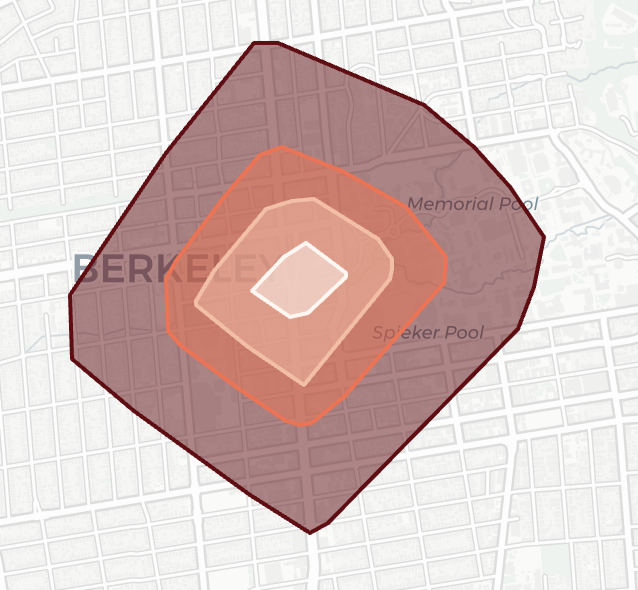

##❗️ Try it Out ❗️
Use the following instructions to fill in the missing values in the code cell below.

**Task 1:** Find all teachable nodes by defining a subgraph that begins at centerNode and explores the network in all directions within the `tripTime` walktimes. The desired output is a smaller graph containing only the reachable nodes.  

**Task 2:** Convert nodes to points
> **Hint:**
```
nodePoints = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
```

**Task 3:** Draw a polygon around the points.  
> **Hint:**
```
boundingPoly = gpd.GeoSeries(nodePoints).union_all().convex_hull
```

**Task 4:** Create a GeoDataFrame to combine time values and polygons into a spatially referenced table.

**Task 5:** Reproject to EPSG:4326 to allow for creation of a web map.


In [8]:
# Edit the code cell below to generate isochrones
isochronePolys = []

for tripTime in sorted(tripTimes, reverse=True):

    # Task 1: Get subgraph of all nodes reachable within tripTime minutes
    # Hint: Use nx.ego_graph() with the projected graph, center node,
    #       radius=tripTime, and distance="time"
    subgraph = nx.ego_graph(
        berkeleyGraphProj,
        centerNode,
        radius=tripTime,
        distance="time"
    ) 

    # Task 2: Convert all nodes in subgraph to Point geometries
    # Hint: List comprehension extracting x,y from node data
    nodePoints = [Point(data['x'], data['y']) for n, data in subgraph.nodes(data=True)]

    # Task 3: Create polygon around the points
    # Hint: GeoSeries → union_all() → convex_hull
    if nodePoints:
        boundingPoly = gpd.GeoSeries(nodePoints).union_all().convex_hull
        isochronePolys.append(boundingPoly)
    else:
        isochronePolys.append(None)

# Task 4: Create GeoDataFrame with trip_time and geometry columns
originIsochrones = gpd.GeoDataFrame({
    'trip_time': tripTimes,
    'geometry': isochronePolys
}, crs=berkeleyGraphProj.graph['crs'])

# Task 5: Reproject back to lat/lon (EPSG:4326) for web mapping
originIsochrones = originIsochrones.to_crs(epsg=4326)
originIsochrones.head()

,trip_time,geometry
0,5,"POLYGON ((-122.26845 37.85733, -122.2816 37.86..."
1,10,"POLYGON ((-122.2668 37.86074, -122.26767 37.86..."
2,15,"POLYGON ((-122.2676 37.86387, -122.27014 37.86..."
3,20,"POLYGON ((-122.26799 37.86751, -122.26973 37.8..."


In [9]:
# Run the following code cell to generate an interactive map
# First, compute areas in the projected CRS (meters) so area calculations are correct
proj_crs = berkeleyGraphProj.graph.get('crs', None)
areas_gdf = originIsochrones.to_crs(proj_crs)

print("\nIsochrone Areas:")
for idx, row in areas_gdf.iterrows():
    areaKm2 = row.geometry.area / 1_000_000  # convert to km² (geometry is in meters)
    print(f"  {originIsochrones.loc[idx,'trip_time']} min walk: {areaKm2:.2f} km²")

# Now create an interactive map in EPSG:4326 (WGS84)
isochroneMap = originIsochrones.explore(
    column='trip_time',
    cmap='YlOrRd',
    tiles="cartodbpositron",
    legend=True,
    tooltip='trip_time',
    style_kwds={'fillOpacity': 0.4},
)

# Display the map object (in notebook this will render the interactive map)
isochroneMap


Isochrone Areas:
  5 min walk: 4.74 km²
  10 min walk: 2.65 km²
  15 min walk: 1.13 km²
  20 min walk: 0.26 km²


# Important Submission Instructions

Submit your work at the end of the class period regardless of whether or not it is complete through Google Assignments.  

Ideally you will have completed up until Part II.  We will continue work on this next week with GTFS data.